In [1]:
import numpy as np
import mne
from utils.loader import unicorn_fs
from utils.feature_extraction import extract_features
from utils.load_dataset import load_dataset, generate_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

mne.set_log_level(verbose='ERROR', return_old_level=False, add_frames=None)

%matplotlib inline
#matplotlib.use("Qt5Agg")

### Preprocessing

1. Read Data
2. Generate Samples 
3. Extract Features

In [2]:
# Read dataset and generate samples

# Playing solo
path_dataset_1 = 'data/dataset/playing_solo'
labels_2 = ['baseline', 'playing']

dataset_1 = load_dataset(path_dataset_1, labels_2)
eeg_baseline_1 = dataset_1['baseline']
eeg_playing = dataset_1['playing']

# Playing and listening
path_dataset_2 = 'data/dataset/playing_listening'
labels_2 = ['baseline', 'relax', 'excited']

dataset_2 = load_dataset(path_dataset_2, labels_2)
eeg_baseline_2 = dataset_2['baseline']
eeg_playing_relax = dataset_2['relax']
eeg_playing_excited = dataset_2['excited']

# Listening
path_dataset_3 = 'data/dataset/listening'
labels_3 = ['baseline', 'relax', 'excited']

dataset_3 = load_dataset(path_dataset_3, labels_3)
eeg_baseline_3 = dataset_3['baseline']
eeg_listening_relax = dataset_3['relax']
eeg_listening_excited = dataset_3['excited']

# -----------------------------------------

window_duration = 4 # seconds
window_size = window_duration * unicorn_fs # samples
window_overlap = 0.875 # percentage

print('\nBaseline 1')
eeg_baseline_samples = generate_samples(eeg_baseline_1, window_size, window_overlap)
print('\nPlaying Solo')
eeg_playing_samples = generate_samples(eeg_playing, window_size, window_overlap)
print('\nBaseline 2')
eeg_baseline_samples_2 = generate_samples(eeg_baseline_2, window_size, window_overlap)
print('\nPlaying Relax')
eeg_playing_relax_samples = generate_samples(eeg_playing_relax, window_size, window_overlap)
print('\nPlaying Excited')
eeg_playing_excited_samples = generate_samples(eeg_playing_excited, window_size, window_overlap)
print('\nBaseline 3')
eeg_baseline_samples_3 = generate_samples(eeg_baseline_3, window_size, window_overlap)
print('\nListening Relax')
eeg_listening_relax_samples = generate_samples(eeg_listening_relax, window_size, window_overlap)
print('\nListening Excited')
eeg_listening_excited_samples = generate_samples(eeg_listening_excited, window_size, window_overlap)

Loading file: data/dataset/playing_solo\baseline\baseline_playing_solo.csv
Loading file: data/dataset/playing_solo\playing\song_playing_solo.csv
Loading file: data/dataset/playing_listening\baseline\baseline_playing_listening_excited.csv
Loading file: data/dataset/playing_listening\relax\song_playing_listening_relax.csv
Loading file: data/dataset/playing_listening\excited\song_playing_listening_excited.csv
Loading file: data/dataset/listening\baseline\baseline_listening_excited.csv
Loading file: data/dataset/listening\relax\song_listening_relax.csv
Loading file: data/dataset/listening\excited\song_listening_excited.csv

Baseline 1
Sample dimension: (1000, 8)
Number of samples: 162

Playing Solo
Sample dimension: (1000, 8)
Number of samples: 452

Baseline 2
Sample dimension: (1000, 8)
Number of samples: 162

Playing Relax
Sample dimension: (1000, 8)
Number of samples: 452

Playing Excited
Sample dimension: (1000, 8)
Number of samples: 452

Baseline 3
Sample dimension: (1000, 8)
Number o

In [3]:
# Extract features
features_playing_solo, baseline_1 = extract_features(eeg_baseline_samples, eeg_playing_samples)
features_playing_listening_relax, baseline_2 = extract_features(eeg_baseline_samples_2, eeg_playing_relax_samples)
features_playing_listening_excited, _ = extract_features(eeg_baseline_samples_2, eeg_playing_excited_samples, baseline_2)
features_listening_relax, baseline_3 = extract_features(eeg_baseline_samples_3, eeg_listening_relax_samples)
features_listening_excited, _ = extract_features(eeg_baseline_samples_3, eeg_listening_excited_samples, baseline_3)

# print
print('\nPlaying Solo:', features_playing_solo.shape)
print('Playing and Listening Relax:', features_playing_listening_relax.shape)
print('Playing and Listening Excited:', features_playing_listening_excited.shape)
print('Listening Relax:', features_listening_relax.shape)
print('Listening Excited:', features_listening_excited.shape)

Extracting bands from sample: 162/162
Extracting bands from sample: 452/452
Extracting bands from sample: 162/162
Extracting bands from sample: 452/452
Extracting bands from sample: 452/452
Extracting bands from sample: 162/162
Extracting bands from sample: 462/462
Extracting bands from sample: 452/452

Playing Solo: (452, 40)
Playing and Listening Relax: (452, 40)
Playing and Listening Excited: (452, 40)
Listening Relax: (462, 40)
Listening Excited: (452, 40)


#### Denoising Autoencoder

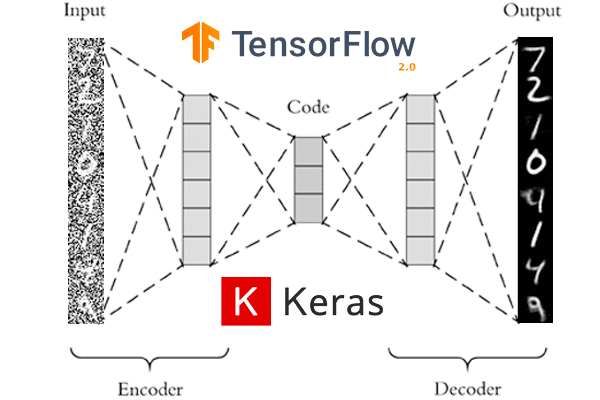


1. Prepare data
2. Define the architecture
3. Train the model
4. Plot Results

##### 1. Prepare Data

In [12]:
# define dataset
n = 450

# X = np.vstack((features_playing_solo[:n], 
#                features_playing_listening_relax[:n], 
#                features_playing_listening_excited[:n]))

# playing_solo_truth = []
# for i in range(n):
#     playing_solo_truth.append(baseline_1)
# playing_solo_truth = np.array(playing_solo_truth)

# y = np.vstack((playing_solo_truth,
#                features_listening_relax[:n],
#                features_listening_excited[:n]))


X = np.vstack((features_playing_listening_relax[:n], 
               features_playing_listening_excited[:n]))

y = np.vstack((features_listening_relax[:n],
               features_listening_excited[:n]))

print(f'X shape: {X.shape}, y shape: {y.shape}')

# number of input columns
n_inputs = X.shape[1]

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X shape: (900, 40), y shape: (900, 40)
X_train shape: (720, 40), y_train shape: (720, 40)
X_test shape: (180, 40), y_test shape: (180, 40)


##### 2. Define autoencoder architecture

In [20]:
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*5/6)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs*4/6)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = int (n_inputs/2)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs*4/6)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*5/6)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

In [32]:
# Convoloutional Autoencoder

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Conv1DTranspose

input = Input(shape=(n_inputs,1))

x = Conv1D(32, 3, activation="relu", padding="same")(input)
x = MaxPooling1D(3,strides =  2,padding="same")(x)
x = Conv1D(64, 3, activation="relu", padding="same")(x)
x = MaxPooling1D(3,strides = 2, padding="same")(x)

# Decoder
x = Conv1DTranspose(64,3, strides=2, activation="relu", padding="same")(x)
x = Conv1DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
x = Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
output = Conv1D(1, 3, activation="tanh", padding="same")(x)

# Autoencoder
model = Model(input, output)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 40, 1)]           0         
                                                                 
 conv1d_28 (Conv1D)          (None, 40, 32)            128       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 20, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 20, 64)            6208      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 10, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 20, 64)           123

##### 3. Train the model

In [44]:
import datetime
import keras.optimizers as optimizers

opt = optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse')
history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))

model.save(f'models/denoising_autoencoder_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5')

Epoch 1/400
45/45 - 2s - loss: 0.3958 - val_loss: 0.2654 - 2s/epoch - 43ms/step
Epoch 2/400
45/45 - 0s - loss: 0.2156 - val_loss: 0.2431 - 380ms/epoch - 8ms/step
Epoch 3/400
45/45 - 0s - loss: 0.2011 - val_loss: 0.2349 - 392ms/epoch - 9ms/step
Epoch 4/400
45/45 - 0s - loss: 0.1955 - val_loss: 0.2291 - 408ms/epoch - 9ms/step
Epoch 5/400
45/45 - 0s - loss: 0.1919 - val_loss: 0.2305 - 403ms/epoch - 9ms/step
Epoch 6/400
45/45 - 0s - loss: 0.1899 - val_loss: 0.2258 - 407ms/epoch - 9ms/step
Epoch 7/400
45/45 - 0s - loss: 0.1871 - val_loss: 0.2250 - 438ms/epoch - 10ms/step
Epoch 8/400
45/45 - 0s - loss: 0.1872 - val_loss: 0.2260 - 500ms/epoch - 11ms/step
Epoch 9/400
45/45 - 0s - loss: 0.1861 - val_loss: 0.2226 - 440ms/epoch - 10ms/step
Epoch 10/400
45/45 - 0s - loss: 0.1851 - val_loss: 0.2250 - 381ms/epoch - 8ms/step
Epoch 11/400
45/45 - 0s - loss: 0.1840 - val_loss: 0.2211 - 447ms/epoch - 10ms/step
Epoch 12/400
45/45 - 0s - loss: 0.1830 - val_loss: 0.2201 - 399ms/epoch - 9ms/step
Epoch 13/40

##### 4. Plot results

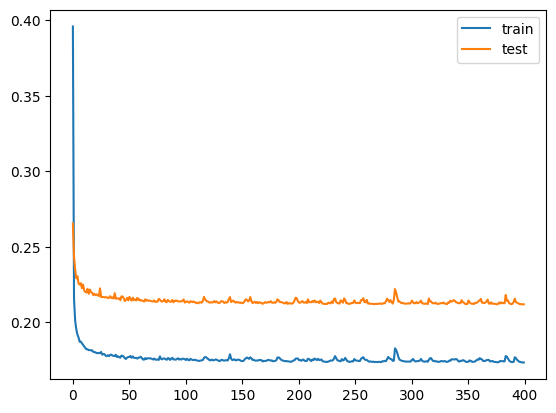

In [45]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()